# MNIST number classification using PyTorch with CUDA
This jupyter notebook provides code for solving handwritten number classification problem.
Model is trained on the GPU using CUDA precompiled binaries for the PyTorch library.

Preparing all the necessary imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

Check if CUDA device is available for the PyTorch

In [2]:
if torch.cuda.is_available():
    print("Using CUDA precompiled version of PyTorch")
else:
    print("Using CPU precompiled version of PyTorch")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using CUDA precompiled version of PyTorch


Prepare transformation for DataLoader. Transformation converts image to a PyTorch tensor and normalizes data points.

In [3]:
transformator = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

Load train and test datasets

In [4]:
train_data = torchvision.datasets.MNIST("data", train=True, download=True, transform=transformator)
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
train_data_iter = iter(train_data_loader)
len(train_data)
print("Number of training images: " + str(len(train_data)))

Number of training images: 60000


In [5]:
test_data = torchvision.datasets.MNIST("data", train=False, download=True, transform=transformator)
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
test_data_iter = iter(test_data_loader)
print("Number of test images: " + str(len(test_data)))

Number of test images: 10000


Check the data

Dimension of the image batch torch.Size([64, 1, 28, 28])
Dimension of the label batch torch.Size([64])
Label for the image below: 3


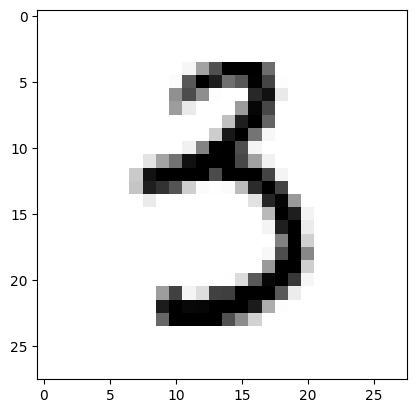

In [6]:
transformed_images, labels = next(train_data_iter)
print("Dimension of the image batch " + str(transformed_images.shape))
print("Dimension of the label batch " + str(labels.shape))
print("Label for the image below: " + str(labels.numpy()[0]))
plt.imshow(transformed_images[0][0].numpy(), cmap='gray_r')

Dimension of the image batch torch.Size([64, 1, 28, 28])
Dimension of the label batch torch.Size([64])
Label for the image below: 7


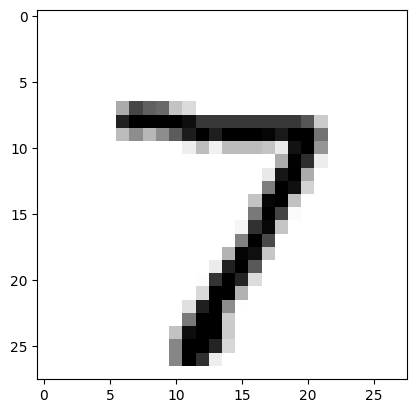

In [7]:
transformed_images, labels = next(test_data_iter)
print("Dimension of the image batch " + str(transformed_images.shape))
print("Dimension of the label batch " + str(labels.shape))
print("Label for the image below: " + str(labels.numpy()[0]))
plt.imshow(transformed_images[0][0].numpy(), cmap='gray_r')

In [8]:
model = nn.Sequential(
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
).to(device)

Training the model

In [9]:
%%time
calculate_loss = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
for i in range(20):
    print("running epoch #" + str(i))
    for images, labels in train_data_loader:
        output_labels = model(images.view(images.shape[0], -1).to(device))
        optimizer.zero_grad()
        loss = calculate_loss(output_labels, labels.to(device))
        loss.backward()
        optimizer.step()


running epoch #0
running epoch #1
running epoch #2
running epoch #3
running epoch #4
running epoch #5
running epoch #6
running epoch #7
running epoch #8
running epoch #9
running epoch #10
running epoch #11
running epoch #12
running epoch #13
running epoch #14
running epoch #15
running epoch #16
running epoch #17
running epoch #18
running epoch #19
CPU times: total: 28min 11s
Wall time: 4min 48s


Testing the model with test data

In [10]:
correct_predictions = [0] * 10
incorrect_predictions = [0] * 10
correct_count, all_count = 0, 0

for images,labels in test_data_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 28 * 28).to(device)
        with torch.no_grad():
            log_prob = model(img)
        probabilities = list(torch.exp(log_prob).cpu().numpy()[0])
        predicted_label = probabilities.index(max(probabilities))
        true_label = labels.numpy()[i]
        if true_label == predicted_label:
            correct_predictions[true_label] += 1
            correct_count += 1
        else:
            incorrect_predictions[true_label] += 1
        all_count += 1

print("Model Accuracy =", (correct_count/all_count))
print("Number of correct predictions for each class: " + str(correct_predictions))
print("Number of incorrect predictions for each class:" + str(incorrect_predictions))

Model Accuracy = 0.9768
Number of correct predictions for each class: [967, 1126, 1005, 979, 954, 876, 940, 999, 935, 987]
Number of incorrect predictions for each class:[13, 9, 27, 31, 28, 16, 18, 29, 39, 22]


Visualisation of incorrect/correct predictions for each class

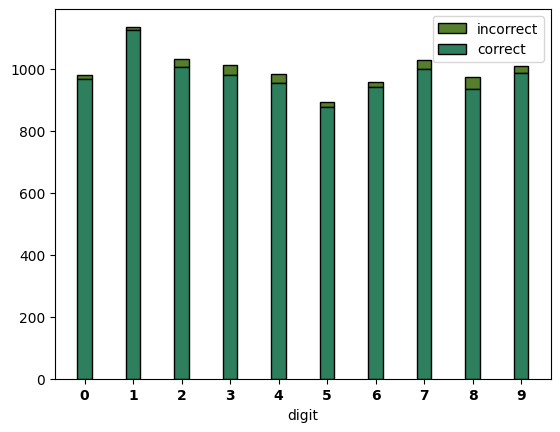

In [12]:
all_labels = range(10)

plt.bar(all_labels, incorrect_predictions, bottom=correct_predictions, color='#557f2d', edgecolor='black', width=.3, label='incorrect')
plt.bar(all_labels, correct_predictions, color='#2d7f5e', edgecolor='black', width=.3, label='correct')

plt.xticks(all_labels, fontweight='bold')
plt.xlabel("digit")
plt.legend()
plt.show()